In [1]:
---
title: Protein Dynamics Simulation
description: Demo
show-code: False
params:
    n_sim:
        label: Number of Simulation
        input: slider
        value: 15
        min: 10
        max: 50
    seq_l:
        label: The maximum length of the Sequence
        input: slider
        value: 20
        min: 15
        max: 30

    k_double:
        label: The location of C=C in the Sequence
        input: slider
        value: 9
        min: 3
        max: 15
    pdb_export:
        input: checkbox
        label: Export simulated data as PDB
        value: True
---

SyntaxError: invalid syntax (3157392170.py, line 1)

In [2]:
# ! pip3 install mljar-mercury

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score
from termcolor import colored
import warnings
import time
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

from Bio.PDB import *
import nglview as nv
import ipywidgets

import math
from scipy.optimize import fsolve
import random

from IPython.display import IFrame

In [4]:
n_sim = 10
seq_l = 30
k_double = 9
pdb_export = True

In [12]:
df = pd.read_csv('data_train.csv')
data_sim = pd.read_csv('data_template.csv')

def p1p2(p1, p2):
    squared_dist = np.sum((p1-p2)**2, axis=0)
    dist = np.sqrt(squared_dist)
    return dist

def dots_distance(data0):
    data = data0.copy()
    data.index = range(len(data))
    distances = []
    for k in range(len(data)-1):
        p1 = data.loc[k, ['X', 'Y', 'Z']]
        p2 = data.loc[k+1, ['X', 'Y', 'Z']]
        #squared_dist = np.sum((p1-p2)**2, axis=0)
        #dist = np.sqrt(squared_dist)
        #distances.append(dist)
        d1 = p1p2(p1, p2)
        distances.append(d1)
    distances.append(0)
    return(distances)

def angle_sign2(p1, p2, p3):
    p1 = list(p1)
    p2 = list(p2)
    p3 = list(p3)
    d1 = np.array(p1) - np.array(p2)
    d2 = np.array(p2) - np.array(p3)
    res = np.dot(d1, d2)
    return 1 if  res> 0 else -1

def get_angle(a, b, c):
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    #sign = angle_sign2(a, b, c)
    return(np.degrees(angle))

def dots_angle(data):
    #data = data0.copy()
    data.index = range(len(data))
    angles = [0]
    for k in range(len(data)-2):
        a = data.loc[k, ['X', 'Y', 'Z']]
        b = data.loc[k+1, ['X', 'Y', 'Z']]
        c = data.loc[k+2, ['X', 'Y', 'Z']]
        angles.append(get_angle(a, b, c))
    angles.append(0)
    return(angles)


# Equation of a plane through three points
# https://kitchingroup.cheme.cmu.edu/blog/2015/01/18/Equation-of-a-plane-through-three-points/
def dots_plane(a, b, c):
    p1 = np.array(list(a))
    p2 = np.array(list(b))
    p3 = np.array(list(c))
    v1 = p3 - p1
    v2 = p2 - p1
    return(np.cross(v1, v2))


def dots_crossprod(a, b, c):
    p1 = np.array(list(a))
    p2 = np.array(list(b))
    p3 = np.array(list(c))
    v1 = p3 - p1
    v2 = p3 - p2
    return(np.cross(v1, v2)+p3)

def dots_plane_d(a, b, c):
    p1 = np.array(list(a))
    p2 = np.array(list(b))
    p3 = np.array(list(c))
    # These two vectors are in the plane
    v1 = p3 - p1
    v2 = p2 - p1
    # the cross product is a vector normal to the plane
    cp = np.cross(v1, v2)
    a, b, c = cp
    # This evaluates a * x3 + b * y3 + c * z3 which equals d
    d = np.dot(cp, p3)
    return (a,b,c,d)


# Function to mirror image
# https://www.geeksforgeeks.org/mirror-of-a-point-through-a-3-d-plane/
def mirror_point(a, b, c, d, x1, y1, z1):
    k = -2*(a*x1 + b*y1 + c*z1 + d)/float((a*a + b*b + c*c))
    x3 = a * k + x1
    y3 = b * k + y1
    z3 = c * k + z1
    return([x3, y3, z3])

# get mirrored point4, given a plane defined by point1, point2, point3 
def get_mirror_xyz(point1, point2, point3, point4):
    p1 = np.array(list(point1))
    p2 = np.array(list(point2))
    p3 = np.array(list(point3))
    p4 = np.array(list(point4))
    offset = p1
    p4 = p4 - offset
    a,b,c,d = dots_plane_d(p1-offset, p2-offset, p3-offset)
    pm = mirror_point(a, b, c, d, p4[0], p4[1], p4[2])
    ans = pm + offset
    return(ans)



def plane_sign(p1, p2, p3, p4):
    p1 = np.array(list(p1))
    p2 = np.array(list(p2))
    p3 = np.array(list(p3))
    p4 = np.array(list(p4))
    v1 = p2 - p1
    v2 = p3 - p2
    v3 = p4 - p3
    return np.dot(v3, np.cross(v1,v2))
    
# Find the Angle between two planes in 3D.
# https://www.geeksforgeeks.org/angle-between-two-planes-in-3d/
def planes_angle(a1, b1, c1, a2, b2, c2):
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return(A)

def surface_angle(data):
    #data = data0.copy()
    data.index = range(len(data))
    angles = [0,0]
    for k in range(len(data)-3):
        a = data.loc[k, ['X', 'Y', 'Z']]
        b = data.loc[k+1, ['X', 'Y', 'Z']]
        c = data.loc[k+2, ['X', 'Y', 'Z']]
        d = data.loc[k+3, ['X', 'Y', 'Z']]
        #e = data.loc[k+4, ['X', 'Y', 'Z']]
        x1, y1, z1 = dots_plane(a,b,c)
        x2, y2, z2 = dots_plane(b,c,d)
        A = planes_angle(x1, y1, z1, x2, y2, z2)
        #sign = 1 if plane_sign(a, b, c, d) >= 0 else -1
        angles.append(A)
    angles.append(0)
    #angles.append(0)
    return(angles)

def dots_extend_mirror(a, b, c):
    a = np.array(list(a))
    b = np.array(list(b))
    c = np.array(list(c))
    v_ab = b - a # vector from point b to a
    v_bc = c - b # vector from point c to b
    c_norm = np.linalg.norm(v_bc) # norm of vector bc
    b_norm = np.linalg.norm(v_ab) # # norm of vector ab
    alpha = get_angle(a, b, c) # dots angle between a, b, c
    v_ad = v_ab + v_ab * (c_norm/b_norm)*np.cos((180-alpha) *np.pi/180) # vector ad extended from vector ab 
    d = v_ad + a # coordinates of middel point d, which is extended from vector ab
    v_cd = d - c # vector from point c to d
    v_ce = v_cd + v_cd # vector ce extended from vector cd
    e = v_ce + c # coordinates of mirrored point e, which is extended from vector cd
    return(e)

def solve_d(data, k):
    a = data.loc[k, ['X', 'Y', 'Z']]
    b = data.loc[k+1, ['X', 'Y', 'Z']]
    c = data.loc[k+2, ['X', 'Y', 'Z']]
    #d = data.loc[k+3, ['X', 'Y', 'Z']]
    feature = data.loc[k+2,["dots-angle", "dots-distance", "planes-angle"]]

    def fn0(w):
        sign = 1
        #sign = angle_sign2(b, c, w)
        return sign*get_angle(b, c, w)

    def fn1(w):
        return p1p2(c, w)

    def fn2(w):
        x1, y1, z1 = dots_plane(a,b,c)
        x2, y2, z2 = dots_plane(b,c,w)
        sign = 1
        #sign = 1 if plane_sign(a, b, c, w) >= 0 else -1
        A = planes_angle(x1, y1, z1, x2, y2, z2)
        return sign*A
    
    def myFunction(w):
       F = np.empty((3))
       F[0] = fn0(w) - feature[0]
       F[1] = fn1(w) - feature[1]
       F[2] = fn2(w) - feature[2]
       return F
    
    wGuess = np.array([0.1, 0.1, 0.1])
    w = fsolve(myFunction,wGuess)
    
    ## w2 is mirror of w from the plane of points a, b, c
    w2 = get_mirror_xyz(a,b,c,w)
    
    ## w3 is mirror of w from extended vector b c
    w3 = dots_extend_mirror(b, c, w)
    
    ## w4 is mirror of w2 from extended vector b c
    w4 = dots_extend_mirror(b, c, w2)
    
    ans = [w, w2, w3, w4]
    #return ans[np.random.choice(3)]
    return ans

def multinorm_sim(ds, k):
    tmp_list = []
    while len(tmp_list) < k:
        tmp = np.random.multivariate_normal(ds.mean(), ds.cov(), 1)
        if (tmp > np.array(ds.min())).prod() and (tmp < np.array(ds.max())).prod():
            tmp_list.append(list(tmp[0]))

    return(np.array(tmp_list))

def sim_seq2(seq_l = 20, k_double = 9, data_sim=data_sim):
    # seq_l = 20
    # k_double = 9
    sim_df = pd.DataFrame(columns = list(data_sim.columns)+['dot_distance3'])
    sim_df
    #seq_l = 20
    #k_double = 9
    sim_df['REMARK'] = range(1,seq_l+1)
    sim_df['4'] = ["C"+str(k) for k in range(1,seq_l+1)]
    sim_df['1DPP'] = ['OLA' for k in range(1,seq_l+1)]
    sim_df['COMPLIES'] = 1
    sim_df['2.0,'] = 1.0
    sim_df['18-NOV-1998'] = 0.0
    #sim_df['18-NOV-1998'] df[df['atom_seq2'] == 'CCCC']['dots-distance'].sample(n=seq_l)

    ds = df[df['atom_seq2']   == 'CCCC'][['dots-angle', 'dots-distance', 'planes-angle','dot_distance3']]
    ds21 = df[df['atom_seq2'] == 'CCCc9'][['dots-angle', 'dots-distance', 'planes-angle','dot_distance3']]
    ds22 = df[df['atom_seq2'] == 'CCc9c10'][['dots-angle', 'dots-distance', 'planes-angle','dot_distance3']]
    ds23 = df[df['atom_seq2'] == 'Cc9c10C'][['dots-angle', 'dots-distance', 'planes-angle','dot_distance3']]
    ds24 = df[df['atom_seq2'] == 'c9c10CC'][['dots-angle', 'dots-distance', 'planes-angle','dot_distance3']]
    ds25 = df[df['atom_seq2'] == 'c10CCC'][['dots-angle', 'dots-distance', 'planes-angle','dot_distance3']]
    
    tmp = pd.DataFrame(multinorm_sim(ds, seq_l),columns=ds.columns)
    #tmp = pd.DataFrame(np.random.multivariate_normal(ds.mean(), ds.cov(), seq_l),columns=ds.columns)
    #tmp = df[df['atom_seq2'] == 'CCCC'][['dots-angle', 'dots-distance', 'planes-angle','dot_distance3']].sample(n=seq_l)
    tmp.index = sim_df.index
    sim_df[['dots-angle', 'dots-distance', 'planes-angle','dot_distance3']] = tmp[['dots-angle', 'dots-distance', 'planes-angle','dot_distance3']]

    # tmp2 = pd.concat([df[df['atom_seq2'] == 'CCCc9'][['dots-angle', 'dots-distance', 'planes-angle','dot_distance3']].sample(n=1),
    #               df[df['atom_seq2'] == 'CCc9c10'][['dots-angle', 'dots-distance', 'planes-angle','dot_distance3']].sample(n=1),
    #               df[df['atom_seq2'] == 'Cc9c10C'][['dots-angle', 'dots-distance', 'planes-angle','dot_distance3']].sample(n=1),
    #               df[df['atom_seq2'] == 'c9c10CC'][['dots-angle', 'dots-distance', 'planes-angle','dot_distance3']].sample(n=1), 
    #               df[df['atom_seq2'] == 'c10CCC'][['dots-angle', 'dots-distance', 'planes-angle','dot_distance3']].sample(n=1)])

#     tmp2 = pd.concat([pd.DataFrame(np.random.multivariate_normal(ds21.mean(), ds21.cov(), 1),columns=ds21.columns),
#                      pd.DataFrame(np.random.multivariate_normal(ds22.mean(), ds22.cov(), 1),columns=ds22.columns),
#                      pd.DataFrame(np.random.multivariate_normal(ds23.mean(), ds23.cov(), 1),columns=ds23.columns),
#                      pd.DataFrame(np.random.multivariate_normal(ds24.mean(), ds24.cov(), 1),columns=ds24.columns),
#                      pd.DataFrame(np.random.multivariate_normal(ds25.mean(), ds25.cov(), 1),columns=ds25.columns)])

    tmp2 = pd.concat([pd.DataFrame(multinorm_sim(ds21, 1),columns=ds21.columns),
                      pd.DataFrame(multinorm_sim(ds22, 1),columns=ds22.columns),
                      pd.DataFrame(multinorm_sim(ds23, 1),columns=ds23.columns),
                      pd.DataFrame(multinorm_sim(ds24, 1),columns=ds24.columns),
                      pd.DataFrame(multinorm_sim(ds25, 1),columns=ds25.columns),
                     ])

    tmp2.index = range(k_double-2, k_double+3)
    for k in range(k_double-2, k_double+3):
        for c in tmp2.columns:
            sim_df.at[k, c] = tmp2.at[k, c]

    #sim_df
    for k in range(3):
        if k == 0:
            sim_df.at[k, 'X'] = 0.0
            sim_df.at[k, 'Y'] = 0.0
            sim_df.at[k, 'Z'] = 0.0
        if k == 1:
            sim_df.at[k, 'X'] = 0.0
            sim_df.at[k, 'Y'] = 0.0
            sim_df.at[k, 'Z'] = sim_df.at[k, 'dots-distance']
        if k == 2:
            delta = 180-sim_df.at[k, 'dots-angle']
            sim_df.at[k, 'Y'] = 0.0
            sim_df.at[k, 'Z'] = np.cos(np.radians(delta)) * sim_df.at[k, 'dots-distance'] + sim_df.at[k-1, 'Z']
            sim_df.at[k, 'X'] = np.sin(np.radians(delta)) * sim_df.at[k, 'dots-distance'] + sim_df.at[k-1, 'X']
    #sim_df

    m = 0
    d = 0
    for k in range(m, len(sim_df)-3):
        xyz_sim = solve_d(sim_df, k)
        #print('SIM: ', xyz_sim)
        #print('OBS: ', list(data_sim.loc[k+3, ['X', 'Y', 'Z']]))
        ## replace observed XYX with simulated XYZ
        p1 = sim_df[['X','Y','Z']].iloc[k]
        l = np.array([p1p2(p1,xyz_sim[0]), p1p2(p1,xyz_sim[1]), p1p2(p1,xyz_sim[2]), p1p2(p1,xyz_sim[3])])
        #d_max = np.argmax(l)
        d_min = np.argmin([abs(sim_df['dot_distance3'].iloc[k+3] - x) for x in l])
        d_random = np.random.choice([0,1,2,3])
        d = np.random.choice([d_min, d_random], p=[0.9999, 0.0001])
        sim_df.at[k+3, 'X'] = xyz_sim[d][0]
        sim_df.at[k+3, 'Y'] = xyz_sim[d][1]
        sim_df.at[k+3, 'Z'] = xyz_sim[d][2]

    return(sim_df)

sim_all = []
for k in range(n_sim):
    tmp_sim = sim_seq2(seq_l, k_double)
    tmp_sim['COMPLIES'] = k+1
    sim_all.append(tmp_sim)
    
sim_df2 = pd.concat(sim_all)
# print("Simulated Data:")
# sim_df2.head()

sim_df2.index = ['ATOM' for k in range(len(sim_df2))]
sim_df2['REMARK'] = range(1,len(sim_df2)+1)

sim_df2['X'] = sim_df2['X'].astype(np.double)
sim_df2['Y'] = sim_df2['Y'].astype(np.double)
sim_df2['Z'] = sim_df2['Z'].astype(np.double)

sim_df2 = sim_df2.round(3)
sim_df2['COMPLIES'] = sim_df2['COMPLIES'].astype(np.int)
sim_df2['REMARK'] = sim_df2['REMARK'].astype(np.int)
sim_df2[['REMARK','4','1DPP', 'COMPLIES', 'X','Y','Z', '2.0,', '18-NOV-1998']].to_csv('data_sim_all.csv', sep =',')

os.system('sh csv2pdb.sh')

0

In [13]:
pdb_parser = PDBParser()
structure = pdb_parser.get_structure("PHA-L", "data_sim_all.pdb")
view = nv.show_biopython(structure)

In [14]:
view

NGLWidget()

In [15]:
view.color_by('atomindex')

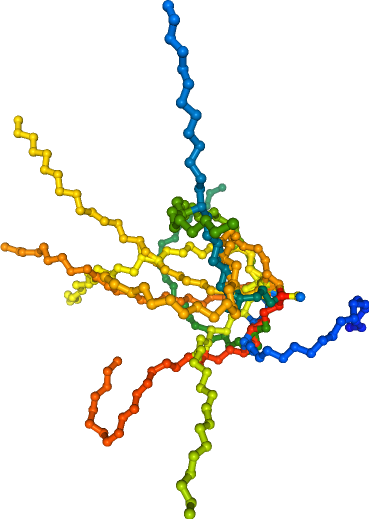

In [17]:
view.render_image(trim=True, factor=2)
view._display_image()

In [18]:
if pdb_export:
    timestamp = int( time.time() )
    os.system('gsutil cp data_sim_all.pdb gs://molecular-dynamics-sim/download/data_sim_all_{}.pdb'.format(timestamp))
    print("PDB Export: https://storage.cloud.google.com/molecular-dynamics-sim/download/data_sim_all_{}.pdb".format(timestamp))
    pdb_df = pd.read_csv('data_sim_all.csv')
    pd.set_option('display.max_rows', pdb_df.shape[0]+1)
    #os.system('cat data_sim_all.pdb')
    display(pdb_df)

PDB Export: https://storage.cloud.google.com/molecular-dynamics-sim/download/data_sim_all_1664301934.pdb


,Unnamed: 0,REMARK,4,1DPP,COMPLIES,X,Y,Z,"2.0,",18-NOV-1998
0,ATOM,1,C1,OLA,1,0.000,0.000,0.000,1.0,0.0
1,ATOM,2,C2,OLA,1,0.000,0.000,1.528,1.0,0.0
2,ATOM,3,C3,OLA,1,1.454,0.000,1.989,1.0,0.0
3,ATOM,4,C4,OLA,1,1.563,-0.959,3.170,1.0,0.0
4,ATOM,5,C5,OLA,1,2.938,-1.616,3.346,1.0,0.0
5,ATOM,6,C6,OLA,1,2.710,-2.497,4.584,1.0,0.0
6,ATOM,7,C7,OLA,1,3.984,-3.318,4.812,1.0,0.0
7,ATOM,8,C8,OLA,1,3.550,-4.750,5.154,1.0,0.0
8,ATOM,9,C9,OLA,1,4.729,-5.670,5.475,1.0,0.0
9,ATOM,10,C10,OLA,1,6.045,-5.339,5.144,1.0,0.0
